# 🛠️ Atelier Analyse & Nettoyage — Flight Delays

---

## 1. Introduction et objectifs
```markdown
> objectif  : découvrir le dataset des retards de vols US, le nettoyer et préparer des DataFrames d’analyse avant de basculer vers la mini-app Streamlit.


## 2. Imports et configuration

In [15]:
# libs
import pandas as pd
import matplotlib.pyplot as plt

# affichage inline
%matplotlib inline

## 3. Chargement initial des données

In [16]:
# 3. Chargement initial des données (colonnes ciblées + types forcés)
cols = ["MONTH","DAY","AIRLINE","ORIGIN_AIRPORT","DEPARTURE_DELAY"]
dtypes = {
    "MONTH": "Int64",
    "DAY": "Int64",
    "AIRLINE": "string",
    "ORIGIN_AIRPORT": "string",
    "DEPARTURE_DELAY": "float64"
}

df = pd.read_csv(
    "flights.csv",
    usecols=cols,
    dtype=dtypes,
    parse_dates=False,
    nrows=200_000,
    low_memory=False
)
print("Taille échantillon :", df.shape)
df.head()


Taille échantillon : (200000, 5)


,MONTH,DAY,AIRLINE,ORIGIN_AIRPORT,DEPARTURE_DELAY
0,1,1,AS,ANC,-11.0
1,1,1,AA,LAX,-8.0
2,1,1,US,SFO,-2.0
3,1,1,AA,LAX,-5.0
4,1,1,AS,SEA,-1.0


## 4. Exploration rapide

In [17]:
print("🔎 Info générales")
df.info()

print("\n🖥️ Statistiques descriptives")
display(df.describe())

print("\n❓ Total de valeurs manquantes par colonne")
display(df.isna().sum().sort_values(ascending=False))

🔎 Info générales
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   MONTH            200000 non-null  Int64  
 1   DAY              200000 non-null  Int64  
 2   AIRLINE          200000 non-null  string 
 3   ORIGIN_AIRPORT   200000 non-null  string 
 4   DEPARTURE_DELAY  195132 non-null  float64
dtypes: Int64(2), float64(1), string(2)
memory usage: 8.0 MB

🖥️ Statistiques descriptives


,MONTH,DAY,DEPARTURE_DELAY
count,200000.0,200000.0,195132.000000
mean,1.0,6.937105,16.952545
std,0.0,3.716896,43.681561
min,1.0,1.0,-42.000000
25%,1.0,4.0,-4.000000
50%,1.0,7.0,1.000000
75%,1.0,10.0,20.000000
max,1.0,13.0,1450.000000



❓ Total de valeurs manquantes par colonne


DEPARTURE_DELAY    4868
MONTH                 0
DAY                   0
AIRLINE               0
ORIGIN_AIRPORT        0
dtype: int64

## 5. Nettoyage et préparation

In [18]:
# 5. Nettoyage des NaN sur DEPARTURE_DELAY
df_clean = df.dropna(subset=["DEPARTURE_DELAY"]).copy()
print("Après suppression des NaN :", df_clean.shape)

# 5.1 Création d’une colonne indicatrice de gros retard (> 15 min)
df_clean["LONG_DELAY"] = (df_clean["DEPARTURE_DELAY"] > 15).astype(int)
display(df_clean.head())


Après suppression des NaN : (195132, 5)


,MONTH,DAY,AIRLINE,ORIGIN_AIRPORT,DEPARTURE_DELAY,LONG_DELAY
0,1,1,AS,ANC,-11.0,0
1,1,1,AA,LAX,-8.0,0
2,1,1,US,SFO,-2.0,0
3,1,1,AA,LAX,-5.0,0
4,1,1,AS,SEA,-1.0,0


## 6. Analyse descriptive

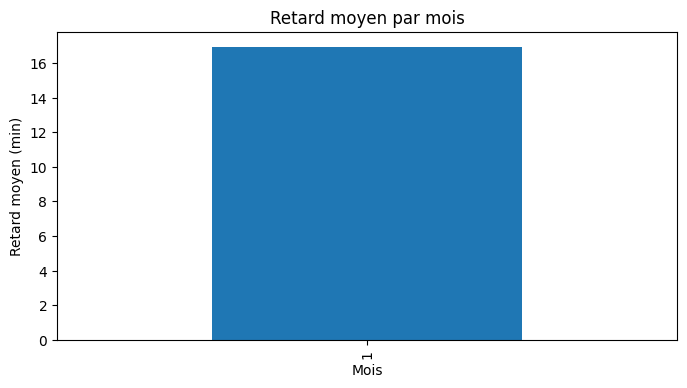

In [19]:
# 6.1 Retard moyen par mois
monthly = df_clean.groupby("MONTH")["DEPARTURE_DELAY"].mean()

fig, ax = plt.subplots(figsize=(8, 4))
monthly.plot(kind="bar", ax=ax)
ax.set_title("Retard moyen par mois")
ax.set_xlabel("Mois")
ax.set_ylabel("Retard moyen (min)")
plt.show()


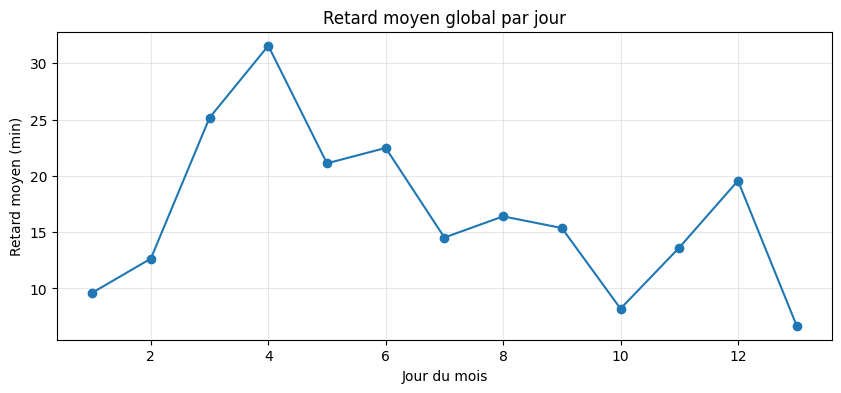

In [20]:
# 6.2 Tendance globale par jour
trend = (
    df_clean
    .groupby("DAY", as_index=False)["DEPARTURE_DELAY"]
    .mean()
    .rename(columns={"DEPARTURE_DELAY": "retard_moyen"})
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(trend["DAY"], trend["retard_moyen"], marker="o")
ax.set_title("Retard moyen global par jour")
ax.set_xlabel("Jour du mois")
ax.set_ylabel("Retard moyen (min)")
ax.grid(alpha=0.3)
plt.show()

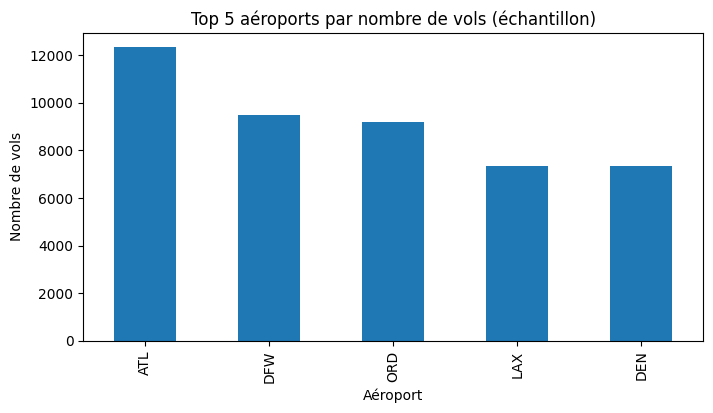

In [21]:
# 6.3 Top 5 compagnies par nombre de vols
top5_airports = df_clean["ORIGIN_AIRPORT"].value_counts().nlargest(5).index
df_top5 = df_clean[df_clean["ORIGIN_AIRPORT"].isin(top5_airports)]

counts = df_clean["ORIGIN_AIRPORT"].value_counts().loc[top5_airports]

fig, ax = plt.subplots(figsize=(8, 4))
counts.plot(kind="bar", ax=ax)
ax.set_title("Top 5 aéroports par nombre de vols (échantillon)")
ax.set_xlabel("Aéroport")
ax.set_ylabel("Nombre de vols")
plt.show()


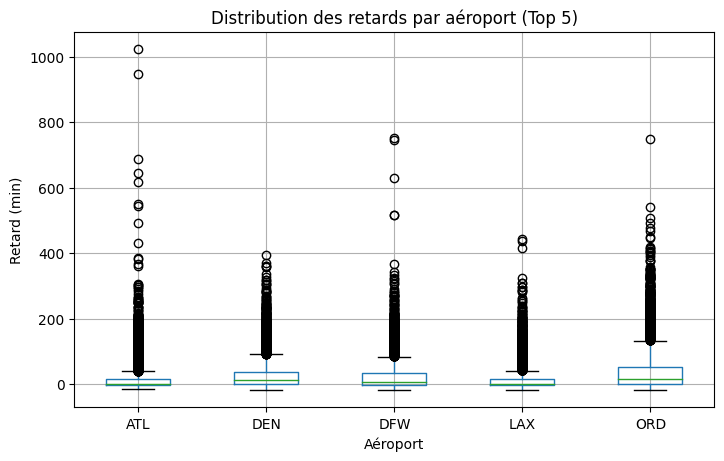

In [22]:
#6.4 Distribution des retards (Boxplot)

fig, ax = plt.subplots(figsize=(8, 5))
df_top5.boxplot(column="DEPARTURE_DELAY", by="ORIGIN_AIRPORT", ax=ax)
ax.set_title("Distribution des retards par aéroport (Top 5)")
ax.set_xlabel("Aéroport")
ax.set_ylabel("Retard (min)")
plt.suptitle("")
plt.show()


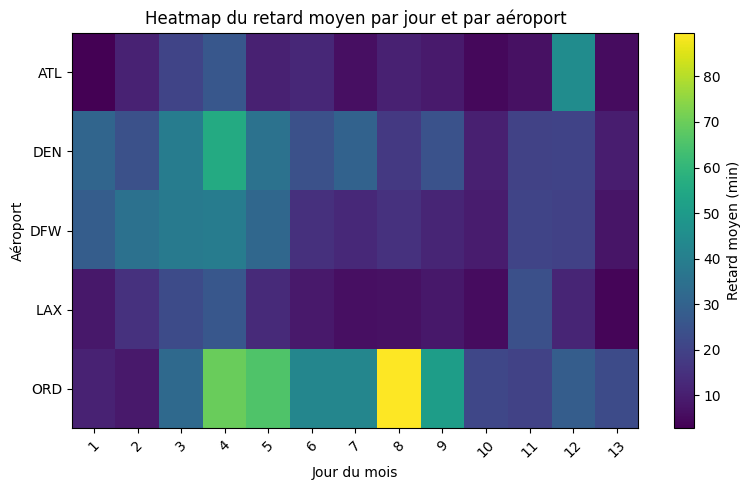

In [23]:
# 6.5 Heatmap retard moyen par jour × aéroport (Top 5)
top5_airports = df_clean["ORIGIN_AIRPORT"].value_counts().nlargest(5).index
df_top5 = df_clean[df_clean["ORIGIN_AIRPORT"].isin(top5_airports)]

# calcul du retard moyen par aéroport et par jour
heatmap_data = (
    df_top5
    .groupby(["ORIGIN_AIRPORT", "DAY"])["DEPARTURE_DELAY"]
    .mean()
    .unstack(level="DAY")
)

fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(heatmap_data, aspect="auto", cmap="viridis")

# labels
ax.set_yticks(range(len(heatmap_data.index)))
ax.set_yticklabels(heatmap_data.index)
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_xticklabels(heatmap_data.columns, rotation=45)
ax.set_title("Heatmap du retard moyen par jour et par aéroport")
ax.set_xlabel("Jour du mois")
ax.set_ylabel("Aéroport")

# colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Retard moyen (min)")

plt.tight_layout()
plt.show()
